In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/MusicProject/Work.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully.")

Unzipped successfully.


In [5]:
import os

print(os.listdir("/content/dataset/Work"))

['keyboard', 'mallet', 'string', 'guitar', 'brass', 'reed', 'vocal', 'flute']


In [6]:
import os
import librosa
import numpy as np

DATASET_PATH = "/content/dataset/Work"

SAMPLE_RATE = 16000
MAX_LEN = SAMPLE_RATE * 4  # 4 seconds

X_healthy = []

for instrument in os.listdir(DATASET_PATH):
    folder = os.path.join(DATASET_PATH, instrument)

    if os.path.isdir(folder):
        for file in os.listdir(folder):
            if file.endswith(".wav"):
                path = os.path.join(folder, file)

                y, sr = librosa.load(path, sr=SAMPLE_RATE)

                # Ensure fixed length
                if len(y) < MAX_LEN:
                    y = np.pad(y, (0, MAX_LEN - len(y)))
                else:
                    y = y[:MAX_LEN]

                X_healthy.append(y)

X_healthy = np.array(X_healthy)

print("Healthy samples shape:", X_healthy.shape)

Healthy samples shape: (5600, 64000)


In [7]:
from scipy.signal import butter, lfilter

def lowpass_filter(y, sr=16000, cutoff=3000):
    nyq = 0.5 * sr
    normal_cutoff = cutoff / nyq
    b, a = butter(4, normal_cutoff, btype='low')
    return lfilter(b, a, y)

def simulate_aging(y):
    y_filtered = lowpass_filter(y)
    y_damped = y_filtered * 0.9
    return y_damped

In [8]:
def simulate_breaking(y):
    noise = np.random.normal(0, 0.02, len(y))
    modulation = np.sin(2 * np.pi * 8 * np.linspace(0, 1, len(y)))
    y_noisy = y + noise
    y_modulated = y_noisy * (1 + 0.15 * modulation)
    return y_modulated

In [9]:
import os
import librosa
import numpy as np
from scipy.signal import butter, lfilter

DATASET_PATH = "/content/dataset/Work"

SAMPLE_RATE = 16000
DURATION = 4
MAX_LEN = SAMPLE_RATE * DURATION
N_MELS = 128

In [10]:
def lowpass_filter(y, sr=16000, cutoff=3000):
    nyq = 0.5 * sr
    normal_cutoff = cutoff / nyq
    b, a = butter(4, normal_cutoff, btype='low')
    return lfilter(b, a, y)

def simulate_aging(y):
    y_filtered = lowpass_filter(y)
    return y_filtered * 0.9

def simulate_breaking(y):
    noise = np.random.normal(0, 0.02, len(y))
    modulation = np.sin(2 * np.pi * 8 * np.linspace(0, 1, len(y)))
    return (y + noise) * (1 + 0.15 * modulation)

In [11]:
def to_mel(y):
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=SAMPLE_RATE,
        n_mels=N_MELS
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_norm = (mel_db + 80) / 80  # normalize to [0,1]
    return mel_norm

In [12]:
X = []
y = []

for instrument in os.listdir(DATASET_PATH):
    folder = os.path.join(DATASET_PATH, instrument)

    if os.path.isdir(folder):
        for file in os.listdir(folder):
            if file.endswith(".wav"):
                path = os.path.join(folder, file)

                # Load waveform
                wav, sr = librosa.load(path, sr=SAMPLE_RATE)

                # Fix length
                if len(wav) < MAX_LEN:
                    wav = np.pad(wav, (0, MAX_LEN - len(wav)))
                else:
                    wav = wav[:MAX_LEN]

                # Healthy
                mel_h = to_mel(wav)
                X.append(mel_h)
                y.append(0)

                # Aged
                wav_aged = simulate_aging(wav)
                mel_a = to_mel(wav_aged)
                X.append(mel_a)
                y.append(1)

                # Broken
                wav_broken = simulate_breaking(wav)
                mel_b = to_mel(wav_broken)
                X.append(mel_b)
                y.append(2)

X = np.array(X)
y = np.array(y)

print("Final shape:", X.shape)
print("Labels shape:", y.shape)

Final shape: (16800, 128, 126)
Labels shape: (16800,)


In [13]:
X = X[..., np.newaxis]

print("New shape:", X.shape)

New shape: (16800, 128, 126, 1)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)

Train: (13440, 128, 126, 1)
Val: (3360, 128, 126, 1)


In [15]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 126, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 124, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,451 (12.61 MB)

 Trainable params: 3,304,451 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.7824 - loss: 0.4074 - val_accuracy: 0.9464 - val_loss: 0.1301
Epoch 2/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9413 - loss: 0.1413 - val_accuracy: 0.9631 - val_loss: 0.0833
Epoch 3/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9563 - loss: 0.1052 - val_accuracy: 0.9548 - val_loss: 0.0964
Epoch 4/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9601 - loss: 0.0985 - val_accuracy: 0.9640 - val_loss: 0.0805
Epoch 5/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9593 - loss: 0.0946 - val_accuracy: 0.9702 - val_loss: 0.0810
Epoch 6/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9667 - loss: 0.0812 - val_accuracy: 0.9664 - val_loss: 0.0787
Epoch 7/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9673 - loss: 0.0745 - val_accuracy: 0.9690 - val_loss: 0.0722
Epoch 8/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9682 - loss: 0.0725 - val_acc

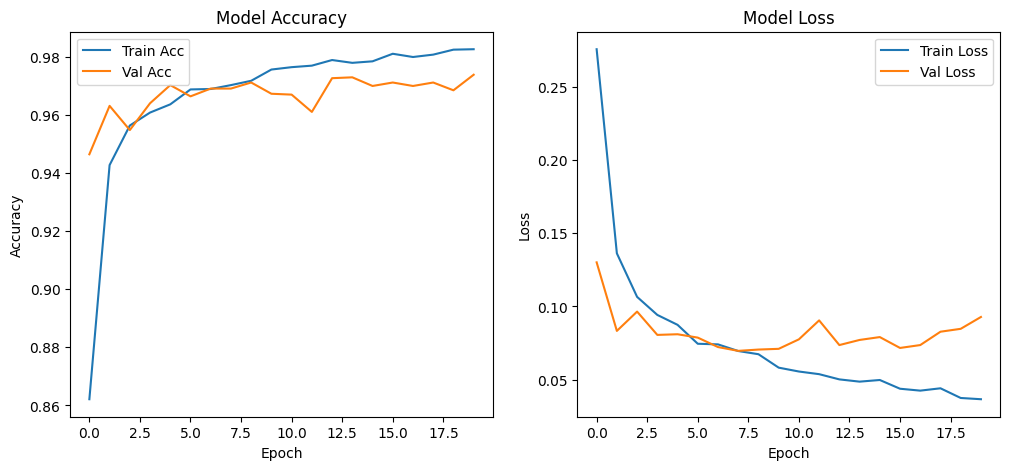

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


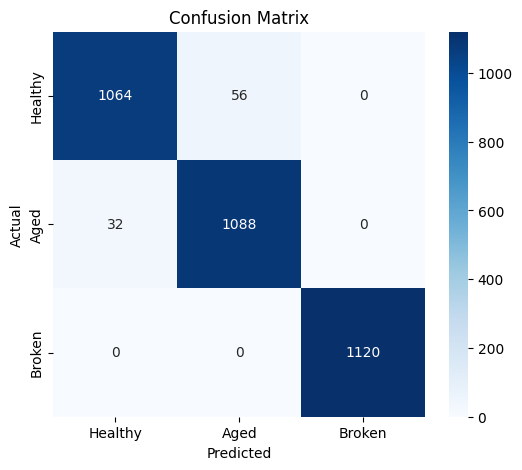

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Healthy','Aged','Broken'],
            yticklabels=['Healthy','Aged','Broken'],
            cmap='Blues')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['Healthy','Aged','Broken']
))

              precision    recall  f1-score   support

     Healthy       0.97      0.95      0.96      1120
        Aged       0.95      0.97      0.96      1120
      Broken       1.00      1.00      1.00      1120

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360



In [21]:
model.save("instrunet_condition.keras")

In [22]:
from google.colab import files
files.download("instrunet_condition.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
model.save("/content/drive/MyDrive/MusicProject/instrunet_condition.keras")